#### Reading binary data and preparing the dataset for autoencoding and class prediction
This notebook shows how to use most of the function provided by the autoencoder side of the BEGepro package:
- Dataset preparation for the autoencoder.
- Autoencoder training and Encoder dimensionality reduction (each waveform represented by 5 points).
- Selecting customizable regions of the energy spectrum (the most populated by SSE or MSE) for a supervised binary classification.
- Classifier training (with a Feed Forward DNN) and final prediction.

In [1]:
# Imports
from begepro.rw import CAENhandler
import matplotlib.pyplot as plt
import numpy as np
import os
import seaborn as sns
import pandas as pd
from sklearn.model_selection import train_test_split
from begepro.dspro import filters as flt
import tensorflow as tf
import pickle
from tensorflow import keras

from begepro.autoencoder.dataloading import DataLoader, Dataset

from numpy.random import seed
from numpy.random import rand

from begepro.autoencoder.autoencoder_classifier import Autoencoder, Classifier

2023-02-10 09:16:13.073681: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-10 09:16:13.166016: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-02-10 09:16:13.166030: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-02-10 09:16:13.662005: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-

The DataLoader class allows for reading .bin files, retrieving useful information and saving to a .npy format. The Dataset class splits the dataset into training/validation/testing subsets and allows for selecting the energy regions for the supervised SSE/MSE classification

In [ ]:
opts = {"loadpath": "/mnt/e/BEGE_data/waveforms_crioconite", # where .bin files are stored
"savepath": "../../dataset/Th232", # where .npy files will be saved with readfiles() and loaded with load()
"subsampling_factor": 3}

dloader = DataLoader(opts)
# dloader.readfiles(1000, 1500, 2650)

waveforms, currents, energies, amplitudes, pulse_height = dloader.load()

dataset = Dataset(waveforms, energies, amplitudes, pulse_height)

train, val, test = dataset.train_val_test_split(0.2, 0.3, 0.4)

In [ ]:
M_ELECTRON = 511

# Training regions must be defined as list [energy_centre, energy_std].
# .get_classification_sample will select the energy range [energy_centre - 2*energy_std, energy_centre + 2*energy_std]


# MSE regions:
region_Tlpeak = [2615, 3]
region_Tlsep = [2615 - 1*M_ELECTRON, 3]
region_train_mcompton = [2500, 32]

# SSE regions:
region_dep = [2615 - 2*M_ELECTRON, 3]
region_cedge = [2250, 60]

region_mse = [region_Tlpeak, region_Tlsep, region_train_mcompton]
region_sse = [region_dep, region_cedge]

wf_train, wf_val, label_train, label_val = dataset.get_classification_sample(train, val, region_mse, region_sse)

Building and training the Autoencoder model. Note that the trained model can be saved by setting "save = True" in the .train() method.

In [ ]:
dense_list = [50, 35, 5, 35, 50] # neurons for each hidden layers of the autoencoder.
lrelu_slopes = [0.05, 0.05, 0.01, 0.05, 0.05] # alpha parameter for the LeakyReLU activation function.
autoencoder = Autoencoder(dense_list, lrelu_slopes)

In [ ]:
autoencoder.train(train[0], val[0], epochs = 10, batch_size = 1000, save = False)
# For reference, a good loss function value should be at least < 5e-5. To achieve this, train the model for ~ 1000 epochs.

Epoch 1/1000
100/100 - 2s - loss: 0.1227 - val_loss: 0.0055 - 2s/epoch - 15ms/step
Epoch 2/1000
100/100 - 1s - loss: 0.0023 - val_loss: 0.0017 - 606ms/epoch - 6ms/step
Epoch 3/1000
100/100 - 1s - loss: 0.0016 - val_loss: 0.0013 - 596ms/epoch - 6ms/step
Epoch 4/1000
100/100 - 1s - loss: 0.0013 - val_loss: 0.0013 - 602ms/epoch - 6ms/step
Epoch 5/1000
100/100 - 1s - loss: 0.0013 - val_loss: 0.0012 - 612ms/epoch - 6ms/step
Epoch 6/1000
100/100 - 1s - loss: 0.0012 - val_loss: 0.0012 - 600ms/epoch - 6ms/step
Epoch 7/1000
100/100 - 1s - loss: 0.0012 - val_loss: 0.0011 - 600ms/epoch - 6ms/step
Epoch 8/1000
100/100 - 1s - loss: 0.0011 - val_loss: 0.0011 - 596ms/epoch - 6ms/step
Epoch 9/1000
100/100 - 1s - loss: 0.0011 - val_loss: 0.0011 - 590ms/epoch - 6ms/step
Epoch 10/1000
100/100 - 1s - loss: 0.0011 - val_loss: 0.0010 - 591ms/epoch - 6ms/step
Epoch 11/1000
100/100 - 1s - loss: 0.0010 - val_loss: 0.0010 - 599ms/epoch - 6ms/step
Epoch 12/1000
100/100 - 1s - loss: 0.0010 - val_loss: 9.7737e-04 

Autoencoder loss for different bottleneck sizes. A size of 5 is a good compromise between dimension reduction and reconstruction error.

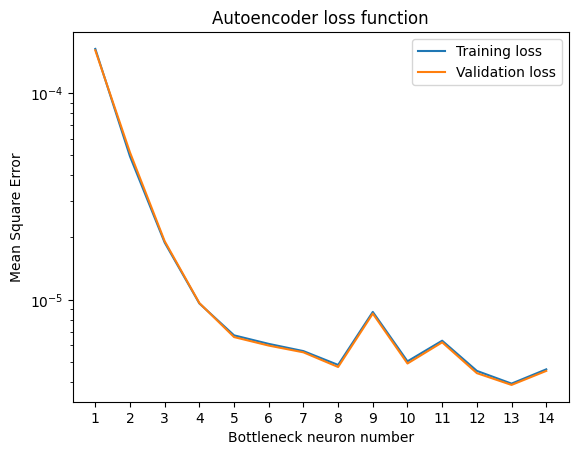

In [ ]:
loss_train = np.loadtxt("../../results/losses_scan_train")
loss_val = np.loadtxt("../../results/losses_scan_val")
bottleneck_sizes = np.linspace(1, 14, 14)
plt.plot(bottleneck_sizes, loss_train)
plt.plot(bottleneck_sizes, loss_val)
plt.xticks(bottleneck_sizes)
plt.xlabel("Bottleneck neuron number")
plt.ylabel("Mean Square Error")
plt.title("Autoencoder loss function")
plt.legend(["Training loss", "Validation loss"])
plt.yscale("log")

Predicting waveforms with the trained Autoencoder

In [ ]:
predicted_waveforms = autoencoder.autoencoder.predict(train[0])

12438/12438 [==============================] - 11s 901us/step


Text(0.5, 0, 'Time (A.U.)')

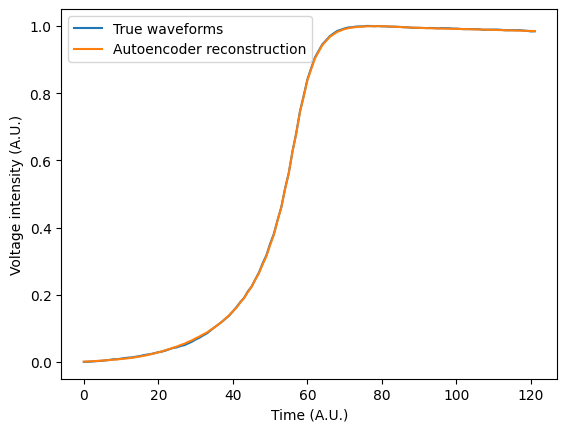

In [ ]:
plt.plot(train[0][0])
plt.plot(predicted_waveforms[0])
plt.legend(["True waveforms", "Autoencoder reconstruction"])
plt.ylabel("Voltage intensity (A.U.)")
plt.xlabel("Time (A.U.)")

Using the Encoder model to encode waveforms

In [ ]:
encoded_training, mus, stds = autoencoder.encode(wf_train)
encoded_val, _, _ = autoencoder.encode(wf_val, mus, stds)

951/951 [==============================] - 1s 858us/step


Plotting the classification dataset. Are the two classes separated?

In [ ]:
np_training_data = np.hstack([encoded_training, label_train.reshape(-1, 1)])
pd_trainin_data = pd.DataFrame(np_training_data, columns = ['var0','var1','var2', 'var3', 'var4', 'label'])

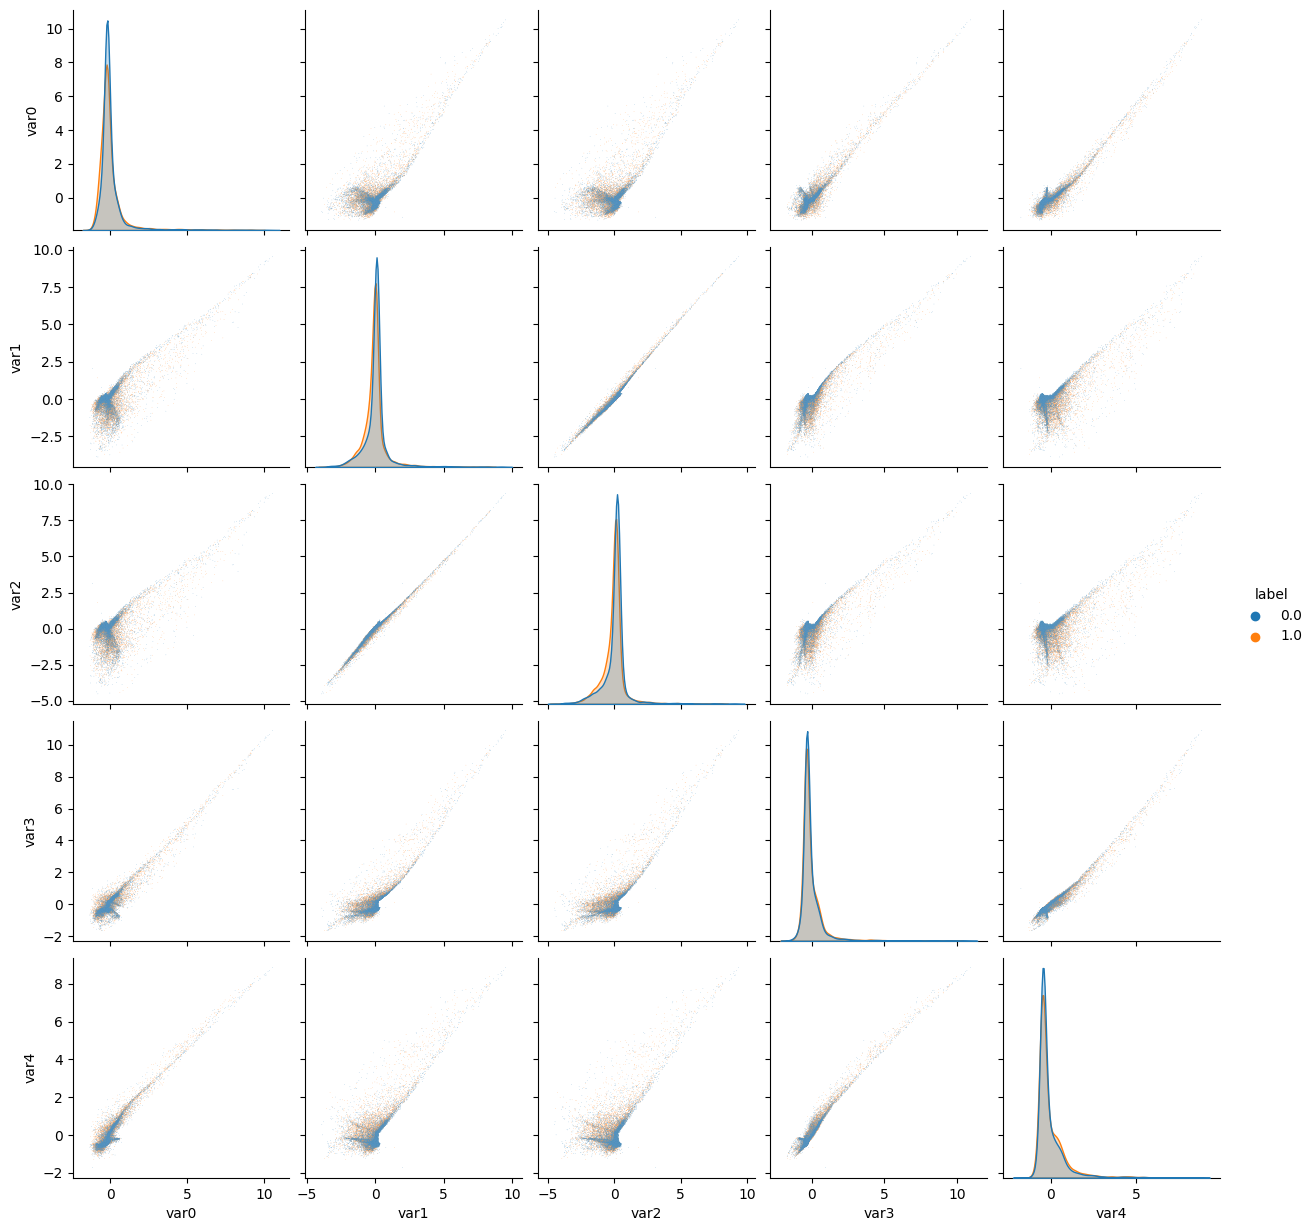

In [ ]:
sns.pairplot(pd_trainin_data, hue="label", plot_kws={"s": 0.1}) # it may take a while to plot

Characterizing representativeness of the supervised classification subsample

In [ ]:
encoded_training_allrange, _, _ = autoencoder.encode(train[0], mus, stds)

12438/12438 [==============================] - 12s 929us/step


In [ ]:
var1_sub = np.histogram(encoded_training[:,0], bins = 20)[0]
var2_sub = np.histogram(encoded_training[:,1], bins = 20)[0]
var3_sub = np.histogram(encoded_training[:,2], bins = 20)[0]
var4_sub = np.histogram(encoded_training[:,3], bins = 20)[0]
var5_sub = np.histogram(encoded_training[:,4], bins = 20)[0]

var1_sub_std = np.sqrt(var1_sub)
var2_sub_std = np.sqrt(var2_sub)
var3_sub_std = np.sqrt(var3_sub)
var4_sub_std = np.sqrt(var4_sub)
var5_sub_std = np.sqrt(var5_sub)


var1 = np.histogram(encoded_training_allrange[:,0], bins = 20)[0]
var2 = np.histogram(encoded_training_allrange[:,1], bins = 20)[0]
var3 = np.histogram(encoded_training_allrange[:,2], bins = 20)[0]
var4 = np.histogram(encoded_training_allrange[:,3], bins = 20)[0]
var5 = np.histogram(encoded_training_allrange[:,4], bins = 20)[0]

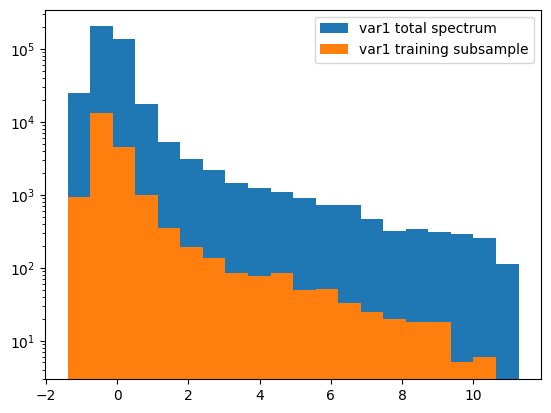

In [ ]:
plt.hist(encoded_training_allrange[:,0], bins = 20, range = [encoded_training_allrange[:,0].min(), encoded_training_allrange[:,0].max()])
plt.hist(encoded_training[:,0], bins = 20, range = [encoded_training_allrange[:,0].min(), encoded_training_allrange[:,0].max()])
plt.yscale("log")
plt.legend(["var1 total spectrum", "var1 training subsample"])

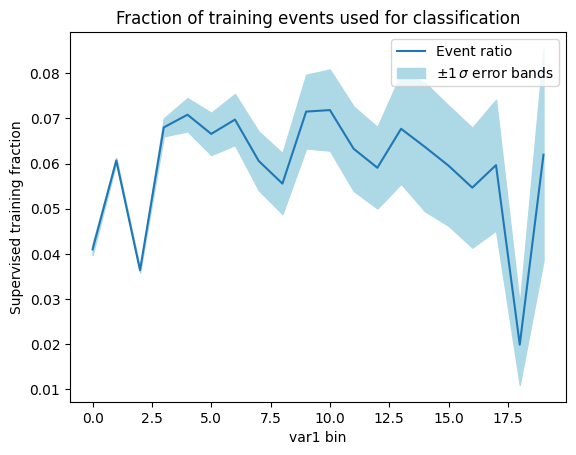

In [ ]:
plt.plot(var1_sub/var1)
plt.fill_between(np.linspace(0, 19, 20), var1_sub/var1 - np.sqrt(var1_sub)/var1, var1_sub/var1 + np.sqrt(var1_sub)/var1, color='lightblue')
plt.title("Fraction of training events used for classification")
plt.xlabel("var1 bin")
plt.ylabel("Supervised training fraction")
plt.legend([r"Event ratio", r"$\pm 1\, \sigma$ error bands"])

Building and training the MSE/SSE classifier. Note that the trained model can be saved by setting "save = True" in the .train() method.

In [ ]:
dense_list = [10, 10]
lrelu_slopes = [0.05, 0.05]
classifier = Classifier(dense_list, lrelu_slopes, input_size = 5)

In [ ]:
classifier.train(encoded_training, label_train, encoded_val, label_val, batch_size = 500, save = False)

Epoch 1/200
42/42 - 1s - loss: 0.7292 - accuracy: 0.5081 - val_loss: 0.7124 - val_accuracy: 0.5298 - 891ms/epoch - 21ms/step
Epoch 2/200
42/42 - 0s - loss: 0.7024 - accuracy: 0.5452 - val_loss: 0.6935 - val_accuracy: 0.5497 - 162ms/epoch - 4ms/step
Epoch 3/200
42/42 - 0s - loss: 0.6893 - accuracy: 0.5570 - val_loss: 0.6870 - val_accuracy: 0.5533 - 140ms/epoch - 3ms/step
Epoch 4/200
42/42 - 0s - loss: 0.6852 - accuracy: 0.5613 - val_loss: 0.6848 - val_accuracy: 0.5609 - 134ms/epoch - 3ms/step
Epoch 5/200
42/42 - 0s - loss: 0.6834 - accuracy: 0.5676 - val_loss: 0.6832 - val_accuracy: 0.5676 - 133ms/epoch - 3ms/step
Epoch 6/200
42/42 - 0s - loss: 0.6813 - accuracy: 0.5742 - val_loss: 0.6807 - val_accuracy: 0.5734 - 135ms/epoch - 3ms/step
Epoch 7/200
42/42 - 0s - loss: 0.6793 - accuracy: 0.5778 - val_loss: 0.6794 - val_accuracy: 0.5767 - 134ms/epoch - 3ms/step
Epoch 8/200
42/42 - 0s - loss: 0.6781 - accuracy: 0.5813 - val_loss: 0.6784 - val_accuracy: 0.5803 - 135ms/epoch - 3ms/step
Epoch 9

Predicting test classes giving the waveforms.

In [ ]:
test_encoded, _, _ = autoencoder.encode(test[0], mus, stds)
test_scores = classifier.classifier.predict(test_encoded)
print("Some scores: ", test_scores[:10])

24875/24875 [==============================] - 21s 852us/step
Some scores:  [[0.06660299]
 [0.5620843 ]
 [0.13888937]
 [0.04333416]
 [0.55135536]
 [0.03861929]
 [0.36458609]
 [0.40273696]
 [0.7488144 ]
 [0.6046525 ]]


The scores are floats between 0 and 1. One must choose a threshold value for discrimination.

In [ ]:
threshold = 0.5 # Customizable
predictions = test_scores > 0.5 # 1 -> MSE   2-> SSE
predictions = predictions[:,0]

Seeing the effect on the energy spectrum. Likely, this notebook won't provide an optimized results, but the 208-Tl Compton edge suppression may be already visible.

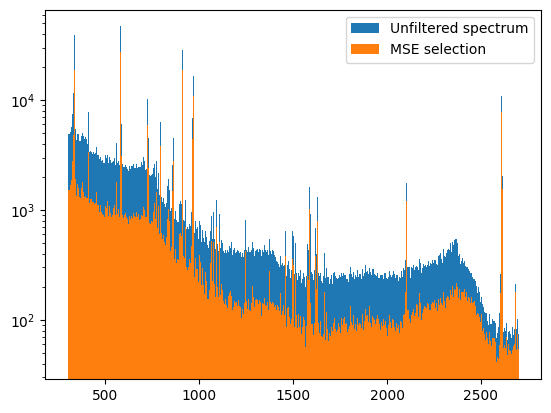

In [ ]:
plt.hist(test[1], bins = 600, range = [300, 2700])[-1]
plt.hist(test[1][predictions], bins = 600, range = [300, 2700])[-1]
plt.yscale("log")
plt.legend(["Unfiltered spectrum", "MSE selection"])